In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 5))

import numpy as np
import scipy.signal as sig
import keras

from keras.layers import Input, Dense, Activation, Dropout
from keras.models import Model
from keras.layers.advanced_activations import ELU
from keras import regularizers
from keras.models import load_model
from keras.initializers import glorot_normal, glorot_uniform
from keras.optimizers import Adam

from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path



Using TensorFlow backend.


## Load data and Preprocessing

In [2]:
# fix random seed for reproducibility
np.random.seed(7)

# Load data and exclude nan value
data = np.genfromtxt('L1O1O2_GPR_earthquakes.txt')
#data1 = np.genfromtxt('Hanfordtestdata.txt')

In [3]:
#####maybe if we cut out the  P waves we can get better results## 
#going to chooose 6000 

#eqgpstime = data[:,0]
#peakgpstime = data[:,24]
#arrivaltime = np.subtract(peakgpstime,eqgpstime)
#distance = data[:,12]
#Velocity = np.divide(distance, arrivaltime)
#pwaveomit = 6000
#Velocity1 = Velocity[Velocity<6000]
#data = data[Velocity<6000]
print (len(data))

2889


In [4]:


########cutting to only use western hemi data, not needed for IRISwest.txt##########
######side note for sky, refernces w/ [:,] instead of np.array
#print(len(data1))
#eq_lon1 =data1[:,11]
#print(eq_lon1)
#data = data1[(eq_lon1>=-180) & (eq_lon1<=-30)]
#print(len(data))
#########cutting out ocean points ############

#eq_lat2 = data[:,11]
#eq_lon2 = data[:,12]
#map1 = Basemap(projection='aeqd', lon_0 = 10, lat_0 = 50, resolution='h')
#lats = eq_lat2  #[:100]                                                                                                        \
                                                                                                                                
#lons = eq_lon2
#x, y = map1(lons, lats)
#locations = np.c_[x, y]
#polygons = [Path(p.boundary) for p in map1.landpolygons]
#result = np.zeros(len(locations), dtype=bool)
#for polygon in polygons:
 #   result += np.array(polygon.contains_points(locations))

#eq_lat1=lats[result]
#eq_lon1=lons[result]
#print (len(data))
#print (result)
#data =data[result]
#print (len(data))




In [5]:
# Extract X and y and divide into train, val, and test set
#X = data[:, [2, 11, 12, 13, 14, 15]] #iris   #side note nikils has log10distnace maybe we should try that
X = data[:, [1, 10, 11, 12, 13, 14]] #L10102, H10102, V10102
#side note nikils has log10distnace maybe we should try that
#X = data1[:, [0, 1, 2, 3, 4, 5]] #from Handford test data with log10 distance

#y = np.log10(data[:, 18]) #iris 
y = np.log10(data[:, 25]) #L10102, H10102, V10102


# Data preprocessing
# Exclude bad data
#z = np.log10(1e-6)
mask = y > -6.0 #-6.5 #(tri's orig)
#mask = y > 1e-6
y = y[mask]
X = X[mask]

###if i were to try and test on all data (good or bad idea?)

print(y.shape)

# Normalizing
X -= np.mean(X, axis=0) #these standard deviations need to be changed if im not doing log?
X /= np.std(X, axis=0)

mean_y = np.mean(y, axis=0)
stdv_y = np.std(y, axis=0)
y = (y-mean_y)/stdv_y

# Shuffle and divide into train and val set
mask = np.random.permutation(X.shape[0]) #(does this work with seed)
X = X[mask]
y = y[mask]

tfrac = int(0.8*y.size) 
X_train = X[:tfrac]
y_train = y[:tfrac]
X_val = X[tfrac:]
y_val = y[tfrac:]

#trying to test against all of itself
#tfrac = int(1*y.size) 
#X_train = X[:tfrac]
#y_train = y[:tfrac]
#X_val = X[:tfrac]
#y_val = y[:tfrac]



print('')
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

(363,)

X_train shape: (290, 6)
y_train shape: (290,)
X_val shape: (73, 6)
y_val shape: (73,)


## Create a DENSE network

In [6]:
def QuakeNet(input_shape, lr=1e-4, reg=0.00, dropout=0.2):
      #orig (input_shape, lr=1e-3, reg=0.00, dropout=0.0)
    X_input = Input(input_shape)
    
    X = Dense(512, kernel_regularizer=regularizers.l2(reg),
              activation='relu')(X_input) 
    
    X = Dense(256, kernel_regularizer=regularizers.l2(reg),
              activation='relu')(X) 
    X = Dense(128, kernel_regularizer=regularizers.l2(reg),
              activation='relu')(X)
    ####X = Dense(16, kernel_regularizer=regularizers.l2(reg),
       ###    #   activation='sigmoid')(X)
    X = Dense(64, kernel_regularizer=regularizers.l2(reg),
             activation='relu')(X)       
    
    X = Dense(32, kernel_regularizer=regularizers.l2(reg),
             activation='relu')(X)
    X = Dense(16, kernel_regularizer=regularizers.l2(reg),
              activation='relu')(X)
    X = Dense(8, kernel_regularizer=regularizers.l2(reg),
              activation='relu')(X)
  #  X = Dense(, kernel_regularizer=regularizers.l2(reg),
           #   activation='relu')(X)
    X = Dropout(rate=dropout)(X)
    X = Dense(1, kernel_regularizer=regularizers.l2(reg))(X)

    model = Model(inputs=X_input, outputs=X, name='QuakeNet')
    model.compile(optimizer=Adam(lr=lr), loss='mse')
#    
    return model

In [7]:
input_shape = (X_train.shape[1], )
model = QuakeNet(input_shape=input_shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               3584      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
__________

## Train

In [8]:
stats = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Train on 290 samples, validate on 73 samples
Epoch 1/50
290/290 [==============================] - 1s 2ms/step - loss: 0.9962 - val_loss: 0.9072
Epoch 2/50
290/290 [==============================] - 0s 110us/step - loss: 0.9472 - val_loss: 0.8663
Epoch 3/50
290/290 [==============================] - 0s 115us/step - loss: 0.8864 - val_loss: 0.8313
Epoch 4/50
290/290 [==============================] - 0s 117us/step - loss: 0.8532 - val_loss: 0.7989
Epoch 5/50
290/290 [==============================] - 0s 114us/step - loss: 0.8355 - val_loss: 0.7690
Epoch 6/50
290/290 [==============================] - 0s 107us/step - loss: 0.7891 - val_loss: 0.7498
Epoch 7/50
290/290 [==============================] - 0s 493us/step - loss: 0.7700 - val_loss: 0.7219
Epoch 8/50
290/290 [==============================] - 0s 133us/step - loss: 0.7451 - val_loss: 0.6847
Epoch 9/50
290/290 [==============================] - 0s 127us/step - loss: 0.6899 - val_loss: 0.6417
Epoch 10/50
290/290 [==================

## Predict

In [9]:
model.save('livgv1.hdf5')
#from keras.model import load_model

model = load_model('livgv1.hdf5')

In [10]:
y_pred = model.predict(X_val) # X_val could be new data too?
# Inverse-normalize
y_val = y_val*stdv_y + mean_y
y_pred = y_pred*stdv_y + mean_y

(73,)


/anaconda3/envs/ligo/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


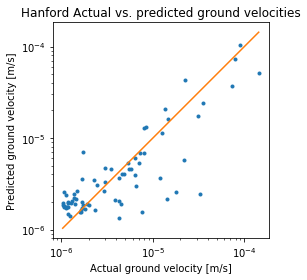

In [11]:
print(y_val.shape)
y_pred = y_pred.flatten()

absy_val = abs(y_val)
absy_pred = abs(y_pred)

#taking antilog so we can see what we are used too 
antiy_val = 10**y_val
antiy_pred = 10**y_pred

v_min = min(np.min(antiy_val), np.min(antiy_pred))
v_max = max(np.max(antiy_val), np.max(antiy_pred))
x = np.linspace(v_min, v_max, 1000)

fig, ax = plt.subplots()

ax.loglog(antiy_val, antiy_pred, '.')
ax.plot(x, x)
ax.set(ylabel='Predicted ground velocity [m/s]', xlabel='Actual ground velocity [m/s]',title = 'Hanford Actual vs. predicted ground velocities' )
ax.set(adjustable='box-forced', aspect='equal')
#ax.axis([yedges.min(),yedges.max(),yedges.min(),yedges.max()])
fig.tight_layout()

plt.savefig('livgroundvel.png', dpi =300,bbox_inches='tight')
#plt.show()



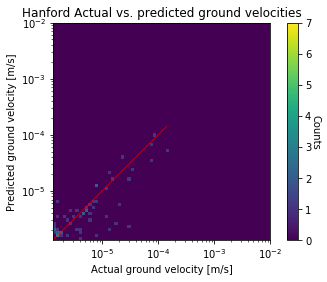

In [12]:
x = np.linspace(v_min, v_max, 1000)
fig2, ax, = plt.subplots()
x_bins = np.logspace(np.log10(antiy_val.min()), np.log10(10e-3),np.sqrt(5000)) #12279
y_bins = np.logspace(np.log10(antiy_pred.min()), np.log10(10e-3),np.sqrt(5000))
H, xedges, yedges = np.histogram2d(antiy_val, antiy_pred, bins=[x_bins,y_bins])
#ax2 = fig.add_subplot(212)
h = ax.pcolormesh(xedges, yedges, H.T)
#ax.set_aspect('equal')
#ax.set(adjustable='box-forced', aspect='equal')
#a2.imshow(img, origin='lower', extent=extent, aspect='auto')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([yedges.min(),yedges.max(),yedges.min(),yedges.max()])
ax.set(ylabel='Predicted ground velocity [m/s]', xlabel='Actual ground velocity [m/s]',title = 'Hanford Actual vs. predicted ground velocities')




cbar = plt.colorbar(h, ax=ax)
ax.plot(x, x, c='r',linewidth=.5)
#ax.set_ylim([0, 10e-2])
#ax.set_xlim([0, 10e-2])
#ax.set_aspect('equal')
#cbar =plt.colorbar()
#cbar.ax.set_ylabel('Counts')
cbar.set_label('Counts', rotation=270,labelpad=9)

fig.tight_layout()
ax.set(adjustable='box', aspect='equal')
plt.savefig('livgroundvelensity.png', dpi =300,bbox_inches='tight')

plt.show()

[0.06150122 0.08215482 1.42354326 0.24086851 0.46309096 3.09549364
 0.63463831 0.76165411 0.56996357 0.09142018 0.26594776 0.08666866
 0.06398617 0.73946764 0.01251021 0.92580615 0.63988586 0.76221772
 0.4956137  0.54229387 0.16774504 0.07620136 0.21076211 0.57285204
 0.31041056 0.60582667 0.14299078 0.57612886 0.30810588 0.3290228
 0.533094   0.07036187 0.6724819  0.78605747 0.1676772  0.49149376
 0.21428206 0.48638666 0.69098626 0.06539639 1.13037711 0.84967299
 0.10052513 0.00720775 0.1339088  0.68551133 0.32900788 0.00962393
 0.09438347 0.44110641 0.10099506 0.79749612 0.38556497 0.68251549
 0.85596513 0.17139426 0.65644309 0.51734564 0.13716473 0.57583113
 0.1534278  0.89720164 0.52013536 0.50901337 0.66743598 0.55567281
 0.89606285 0.00549657 1.09221091 0.56207482 0.02164058 0.51753846
 0.25485218]
(73,)
0.005496565395213271
3.0954936413440843
0.47605196947064055


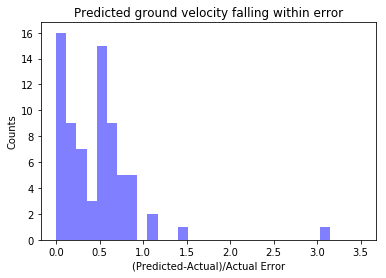

In [13]:
z = np.array(abs((antiy_val -antiy_pred)/antiy_val))

print(z)
print(z.shape)
print(np.min(z))
print(np.max(z))
print (np.average(z))
#x_bins = np.logspace(np.log10(antiy_val.min()), np.log10(antiy_val.max()),np.sqrt(12279))
#y_bins = np.logspace(np.log10(antiy_pred.min()), np.log10(antiy_pred.max()),np.sqrt(12279))
plt.hist(z, bins=30,range =[0,3.5], facecolor='blue', alpha=0.5)
plt.xlabel('(Predicted-Actual)/Actual Error')
plt.ylabel('Counts')
plt.title('Predicted ground velocity falling within error')
plt.savefig('livgroundvelhist1.png', dpi =300,bbox_inches='tight')
plt.show()